In [14]:
setwd("/staging/leuven/stg_00041/Bradley/rivronData/")

In [15]:
#analyzing rivron counts 
load("/staging/leuven/stg_00041/Bradley/rivronData/rivronLoaded.counts.Robject")

In [16]:
library(umap)
library(ggplot2)
library(Seurat)
library(reshape2)
library(viridis)
library(AUCell)

Attaching SeuratObject

Loading required package: viridisLite



In [4]:
metaData <- read.table("/staging/leuven/stg_00041/Bradley/rivronData/rivron.metadata.tsv", sep="\t", h=T)

#for matching metaData to loaded, I need the 2nd of _ separated in loaded colnames match to sample.name from metaData. might be in the right order already

colNameSep <- data.frame(colName=colnames(rivronLoaded), sampleName=NA)
for(i in 1:nrow(colNameSep)){
    colNameSep$sampleName[i]<- strsplit(colnames(rivronLoaded)[i], split="_")[[1]][2]
}

head(colNameSep)
summary(colNameSep$sampleName%in%metaData$Sample.name)

summary(metaData$Sample.name==colNameSep[,2])
#matching worked, but they were already in perfect order

,colName,sampleName
,<chr>,<chr>
1,primed_H9-150182,H9-150182
2,primed_H9-150183,H9-150183
3,primed_H9-150185,H9-150185
4,primed_H9-150187,H9-150187
5,primed_H9-150188,H9-150188
6,primed_H9-150189,H9-150189


   Mode   FALSE 
logical    3006 

   Mode   FALSE    NA's 
logical    2899     107 

In [5]:
metaData$type <- NA
for(i in 1:nrow(metaData)){
    metaData$type[i]<- strsplit(as.character(metaData$title[i]), split="-")[[1]][1]
}

In [6]:
umapConfig=umap.defaults
umapConfig$random_state=1234

umapRivron <- umap(t(rivronLoaded), config=umapConfig)

primed_H9-150182,16.70131,-3.647572
primed_H9-150183,16.90546,-2.706680
primed_H9-150185,16.84665,-2.648776
primed_H9-150187,16.59478,-3.723743
primed_H9-150188,16.93952,-3.258945
primed_H9-150189,17.02089,-2.919482


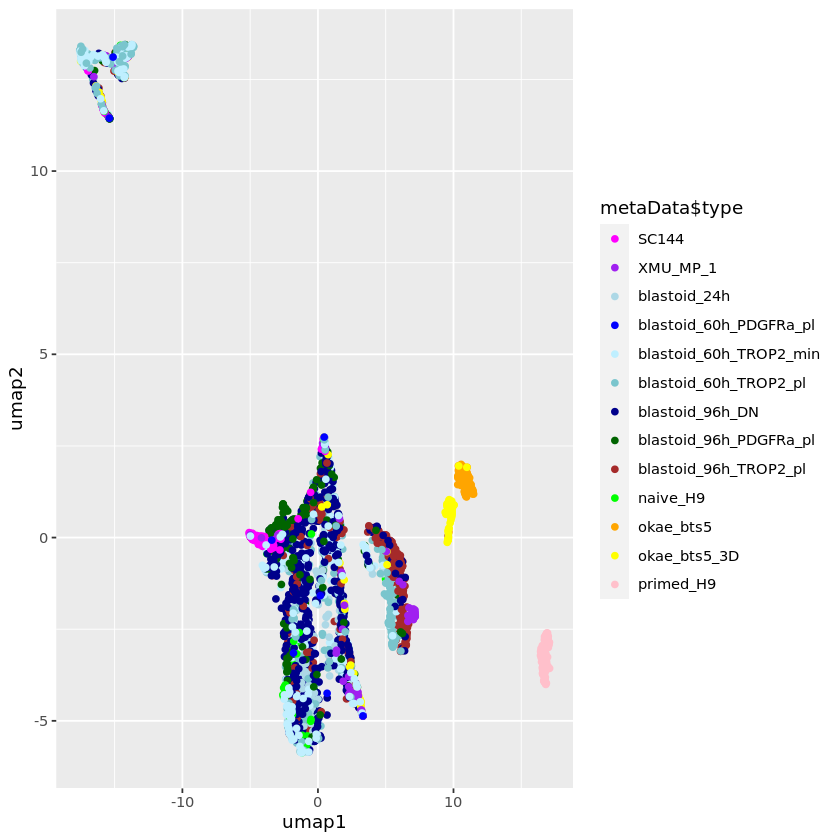

In [7]:
head(umapRivron$layout)

umapRivron$graphable <- data.frame(umapRivron$layout)
colnames(umapRivron$graphable) <- c("umap1", "umap2")


ggplot(data.frame(umapRivron$graphable), aes(x=umap1, y=umap2, color=metaData$type))+geom_point()+
scale_color_manual(values=c("magenta", "purple", "light blue", "blue", "lightblue1", "cadetblue3", "dark blue", "dark green", "brown", "green", "orange", "yellow", "pink"))

In [ ]:
head(metaData)
table(metaData$type, metaData$source.name)

In [8]:
colnames(rivronLoaded)<- metaData$title

In [9]:
load("rivronGeneIDs.Robject")
head(geneIDs)#matching ensemble gene id to gene name

summary(geneIDs$GENEID%in%rownames(rivronLoaded))

#there are less geneIDs than rownames, so I will have to match

,SYMBOL,GENEID,chr
,<chr>,<chr>,<chr>
1,TSPAN6,ENSG00000000003,chrX
2,TNMD,ENSG00000000005,chrX
3,DPM1,ENSG00000000419,chr20
4,SCYL3,ENSG00000000457,chr1
5,C1orf112,ENSG00000000460,chr1
6,FGR,ENSG00000000938,chr1


   Mode   FALSE 
logical   56521 

In [10]:
summary(rownames(rivronLoaded)[which(rownames(rivronLoaded)%in%geneIDs$GENEID)]==geneIDs$GENEID)

rownames(rivronLoaded)[which(rownames(rivronLoaded)%in%geneIDs$GENEID)] <- geneIDs$SYMBOL

   Mode 
logical 

In [12]:
rownames(rivronLoaded)<- make.unique(rownames(rivronLoaded))

In [13]:
rownames(rivronLoaded)[which(rownames(rivronLoaded)=="T")] <- "TBXT"

In [ ]:

write.table(rivronLoaded, "/staging/leuven/stg_00041/Bradley/rivronData/rivronBlastoids.hg38.counts.tsv", sep="\t", row.names=T, col.names=T, quote=F)

In [78]:
save(rivronLoaded, file="/staging/leuven/stg_00041/Bradley/rivronData/rivronLoaded.counts.Robject")

<h2> creating Seurat object</h2>

In [32]:
#only run one of the next 2 cells

#for full rivron. 
rivronSeurat <- CreateSeuratObject(counts=rivronLoaded, project="rivronData", min.cells=3, min.features=200)

Warning message:
"The following arguments are not used: row.names"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [14]:
#for only 96h blastoids
rivronSeurat <- CreateSeuratObject(counts=rivronLoaded[,which(metaData$type%in%c("primed_H9", "naive_H9", "blastoid_96h_TROP2_pl", "blastoid_96h_PDGFRa_pl", "blastoid_96h_DN"))], project="rivronData", min.cells=3, min.features=200)

Warning message:
"The following arguments are not used: row.names"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


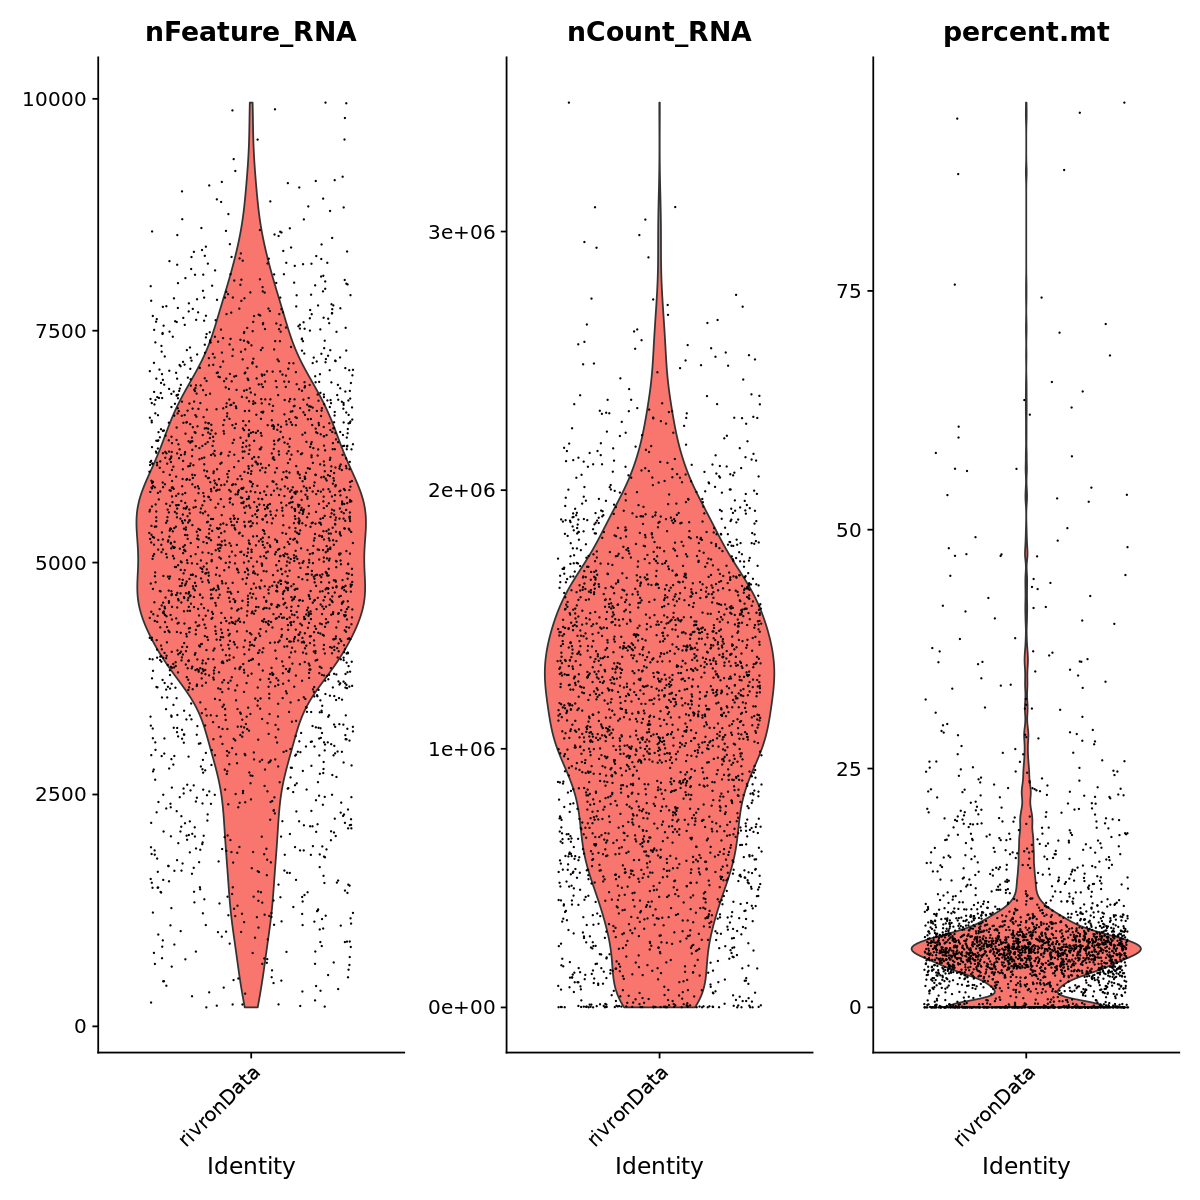

In [34]:
rivronSeurat[["percent.mt"]] <- PercentageFeatureSet(rivronSeurat, pattern="^MT-")
VlnPlot(rivronSeurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), pt.size=0.01, ncol = 3)

[1] 2089

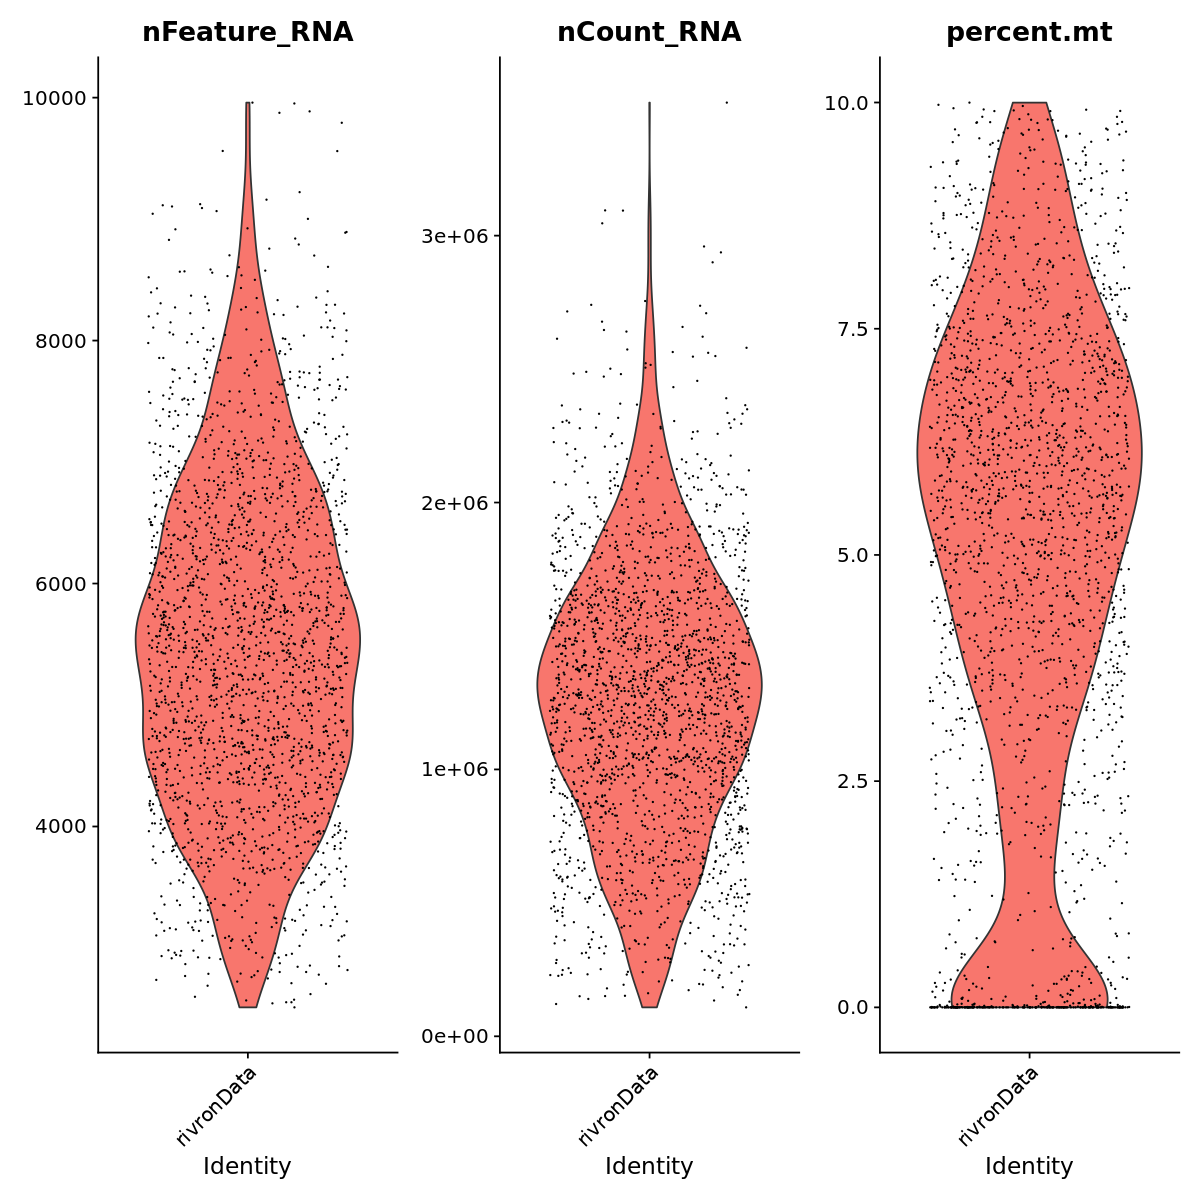

In [35]:
filter_check <- subset(rivronSeurat, subset = nFeature_RNA > 2500 &nCount_RNA >100000 & percent.mt < 10)
VlnPlot(filter_check, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), pt.size=0.01, ncol = 3)

ncol(filter_check)
#only keeps 1010 cells at %MT<5, 2232 at %MT<10. MT is mitochondrial reads
#are 2/3 of these cells dead
#https://satijalab.org/seurat/archive/v3.0/pbmc3k_tutorial.html uses <5% MT to control for low quality/dying cells

In [36]:
#going with MT<10 and nfeatures>2500
rivronSeurat <- subset(rivronSeurat, subset = nFeature_RNA > 2500 &nCount_RNA >100000  & percent.mt < 10)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 95 rows containing missing values (geom_point)."


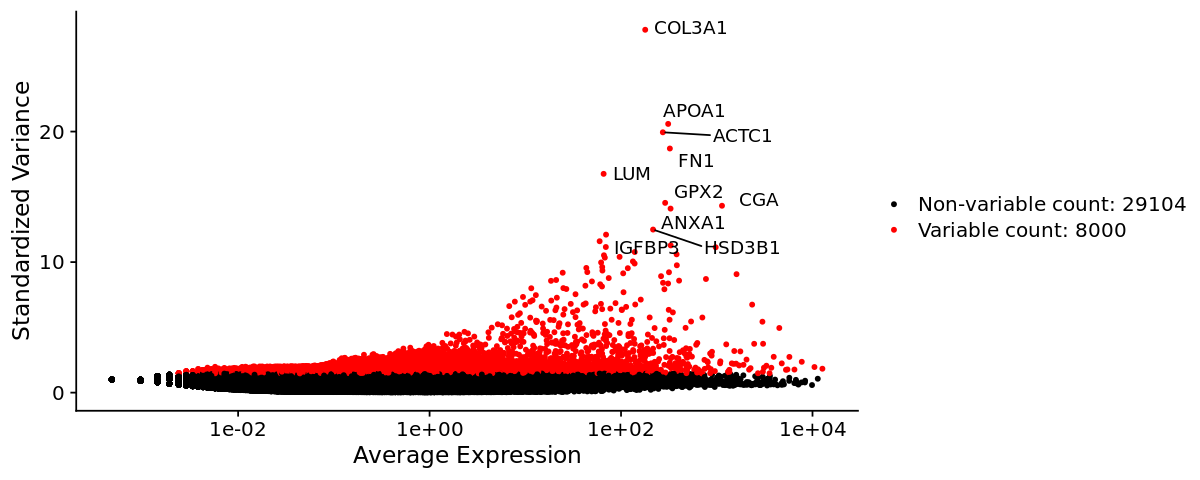

In [37]:
options(repr.plot.width=10, repr.plot.height=4)

rivronSeurat <- FindVariableFeatures(rivronSeurat, selection.method = "vst", nfeatures = 8000)

top10 <- head(VariableFeatures(rivronSeurat), 10)

plot1 <- VariableFeaturePlot(rivronSeurat)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

In [38]:
all.genes <- rownames(rivronSeurat)
normalizedSeurat <- NormalizeData(rivronSeurat, assay = "RNA")
rivronSeurat <- ScaleData(rivronSeurat, features = all.genes)

Centering and scaling data matrix



In [39]:
rivronSeurat <- RunPCA(rivronSeurat, features = VariableFeatures(object = rivronSeurat))

PC_ 1 
Positive:  DPPA5, IFITM1, KHDC3L, GDF3, RP11-267L5.1, NLRP7, SUSD2, TUBB4A, ATG3, TDGF1 
	   DNMT3L, USP28, STOM, PRDM14, SNHG23, PYGB, ABCA1, DPPA3, CBFA2T2, WARS 
	   SCGB3A2, IFITM3, TBC1D23, OLAH, ASS1, SLC6A8, EFR3B, ARGFX, SERINC5, MEG3 
Negative:  MGST3, S100A11, B2M, TMSB10, GTSF1, CD99, ADK, CLU, WBP5, FTH1 
	   UCA1, S100A10, MT-ND3, ARHGDIB, COTL1, CAST, SMS, LGALS1, FOLR1, S100A6 
	   LGALS3, RP11-10A14.5, KRT7, ETFA, PFKP, FTL, MT-ATP6, MPZL1, GATA3, MT-CO3 
PC_ 2 
Positive:  ANXA2, SLC7A2, SNX2, KRT18, KRT8, GATA2, SLC7A8, CLDN4, TACC1, GRHL1 
	   EFNA1, CCKBR, REEP1, FABP5, SELT, SLC3A2, ABCG2, PTN, SMPDL3A, SLC7A7 
	   VGLL1, DPPA3, LAMA1, PKP2, BIN2, NR2F2, DAB2, KRT19, LRP2, GATA3 
Negative:  AP1S2, RARRES2, NME4, OCIAD2, BEX1, TMSB15A, TERF1, BST2, AASS, MFGE8 
	   IGFBPL1, RP11-1144P22.1, USP44, UCHL1, JAKMIP2-AS1, USP9X, B3GALT1, SPATC1L, CSRP2, TMSB4X 
	   RP11-568A7.4, MAD2L2, SOX11, RP11-20D14.6, LECT1, FEZ1, PCK2, ESRG, MARCKSL1, FZD7 
PC_ 3 
Positive:  

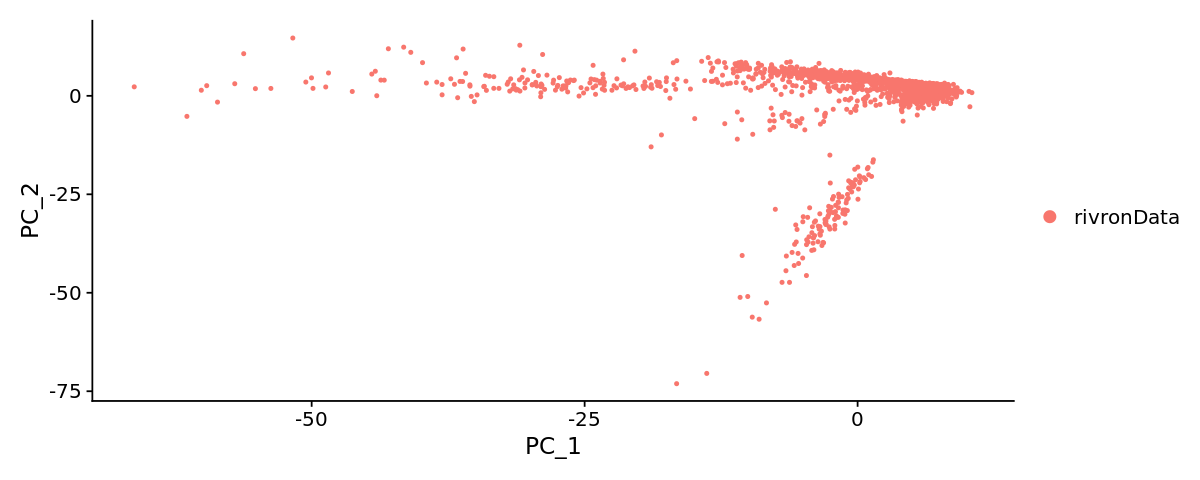

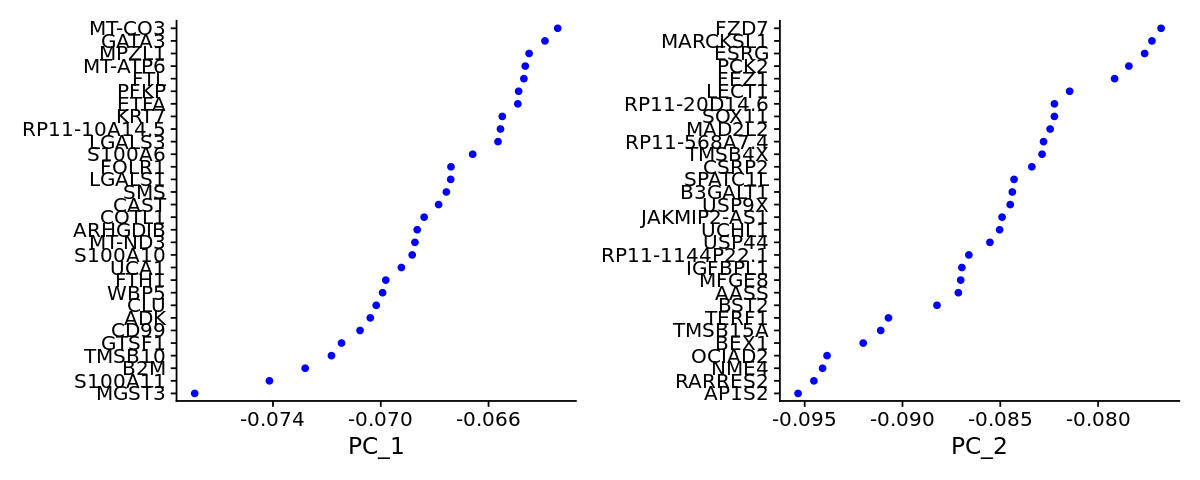

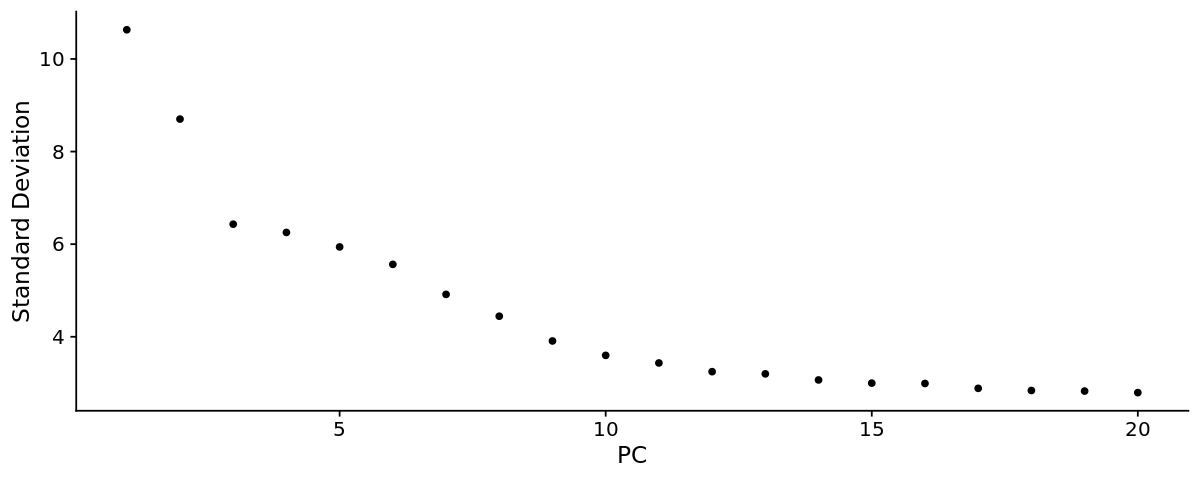

In [40]:
DimPlot(object = rivronSeurat, reduction = "pca")
VizDimLoadings(rivronSeurat, dims = 1:2, reduction = "pca")
ElbowPlot(rivronSeurat)

In [41]:
rivronSeurat <- FindNeighbors(rivronSeurat, dims = 1:10)
rivronSeurat <- FindClusters(rivronSeurat, resolution = 0.8)

# Look at cluster IDs of the first 5 cells
head(Idents(rivronSeurat), 5)


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2089
Number of edges: 59658

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8661
Number of communities: 14
Elapsed time: 0 seconds


primed_H9-150182 primed_H9-150183 primed_H9-150185 primed_H9-150187 primed_H9-150188 
               6                6                6                6                6 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13

In [42]:
summary(rivronLoaded[which(rownames(rivronLoaded)=="NANOG"),])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   45.92   62.00  657.00 

In [43]:
filteredMeta <- data.frame(id=colnames(rivronSeurat), type=NA)

for(i in 1:nrow(filteredMeta)){
    filteredMeta$type[i] <- strsplit(colnames(rivronSeurat)[i], split="-")[[1]][1]
}

rivronSeurat@meta.data$type <- filteredMeta$type

In [47]:

    rivronSeurat <- RunTSNE(rivronSeurat, dims = 1:20, seed.use = 1234, perplexity = 20) 
    rivronSeurat <- RunUMAP(rivronSeurat,dims=1:20)


14:40:39 UMAP embedding parameters a = 0.9922 b = 1.112

14:40:39 Read 2089 rows and found 20 numeric columns

14:40:39 Using Annoy for neighbor search, n_neighbors = 30

14:40:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:40:40 Writing NN index file to temp file /tmp/RtmpGkz9dX/file8e414e697141

14:40:40 Searching Annoy index using 1 thread, search_k = 3000

14:40:40 Annoy recall = 100%

14:40:41 Commencing smooth kNN distance calibration using 1 thread

14:40:41 Initializing from normalized Laplacian + noise

14:40:41 Commencing optimization for 500 epochs, with 80688 positive edges

14:40:48 Optimization finished



In [48]:
rivronSeurat <- FindNeighbors(rivronSeurat, dims = 1:10)
rivronSeurat <- FindClusters(rivronSeurat, resolution = 0.2)


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2089
Number of edges: 59658

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9339
Number of communities: 8
Elapsed time: 0 seconds


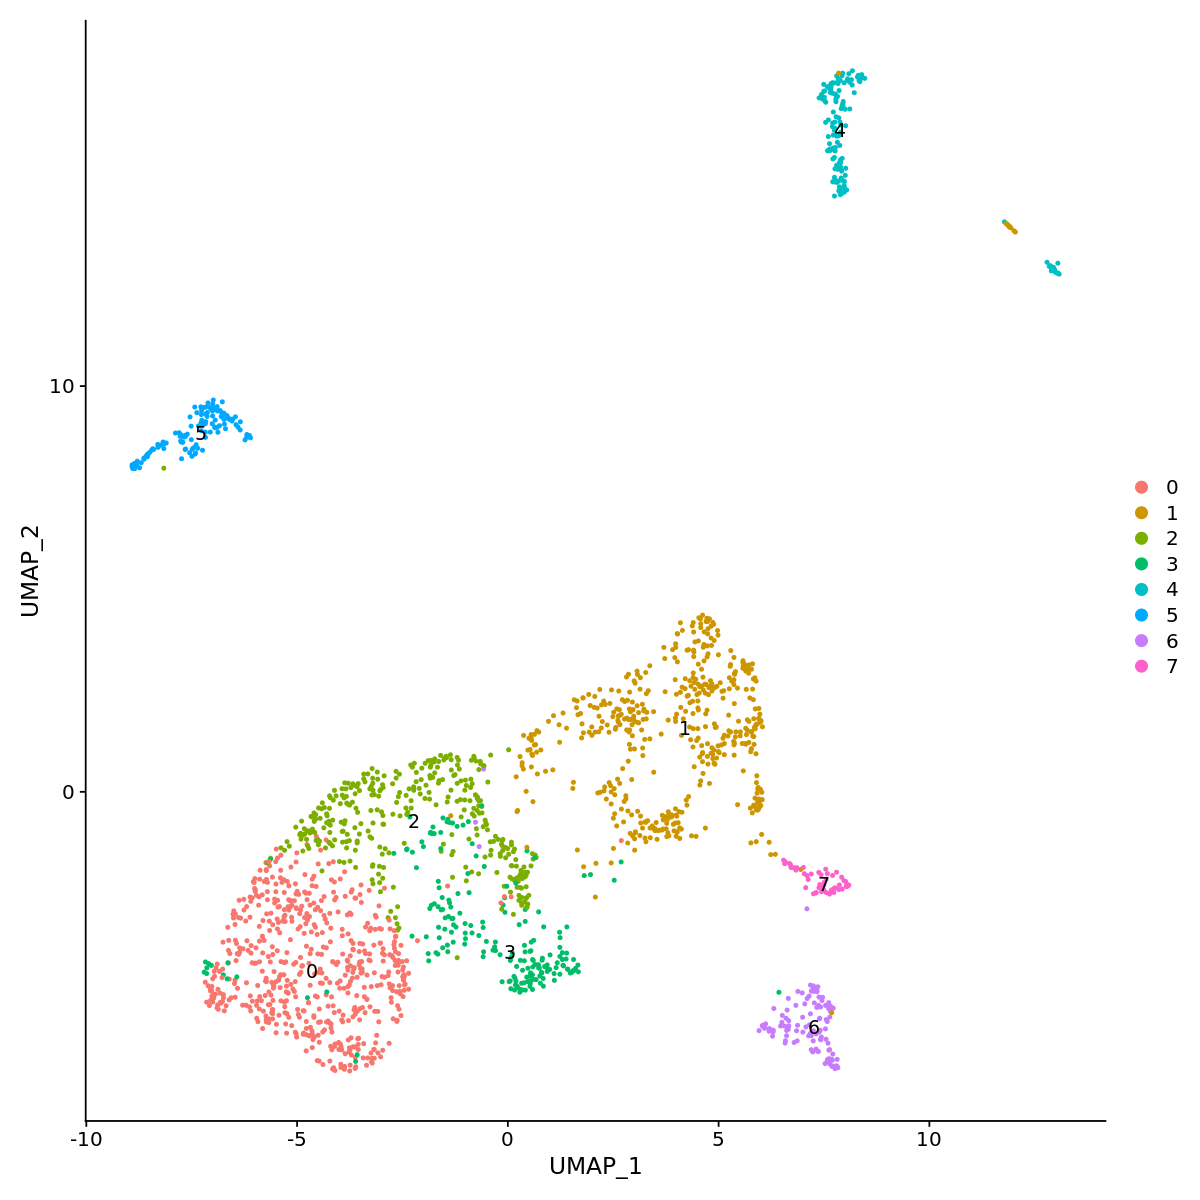

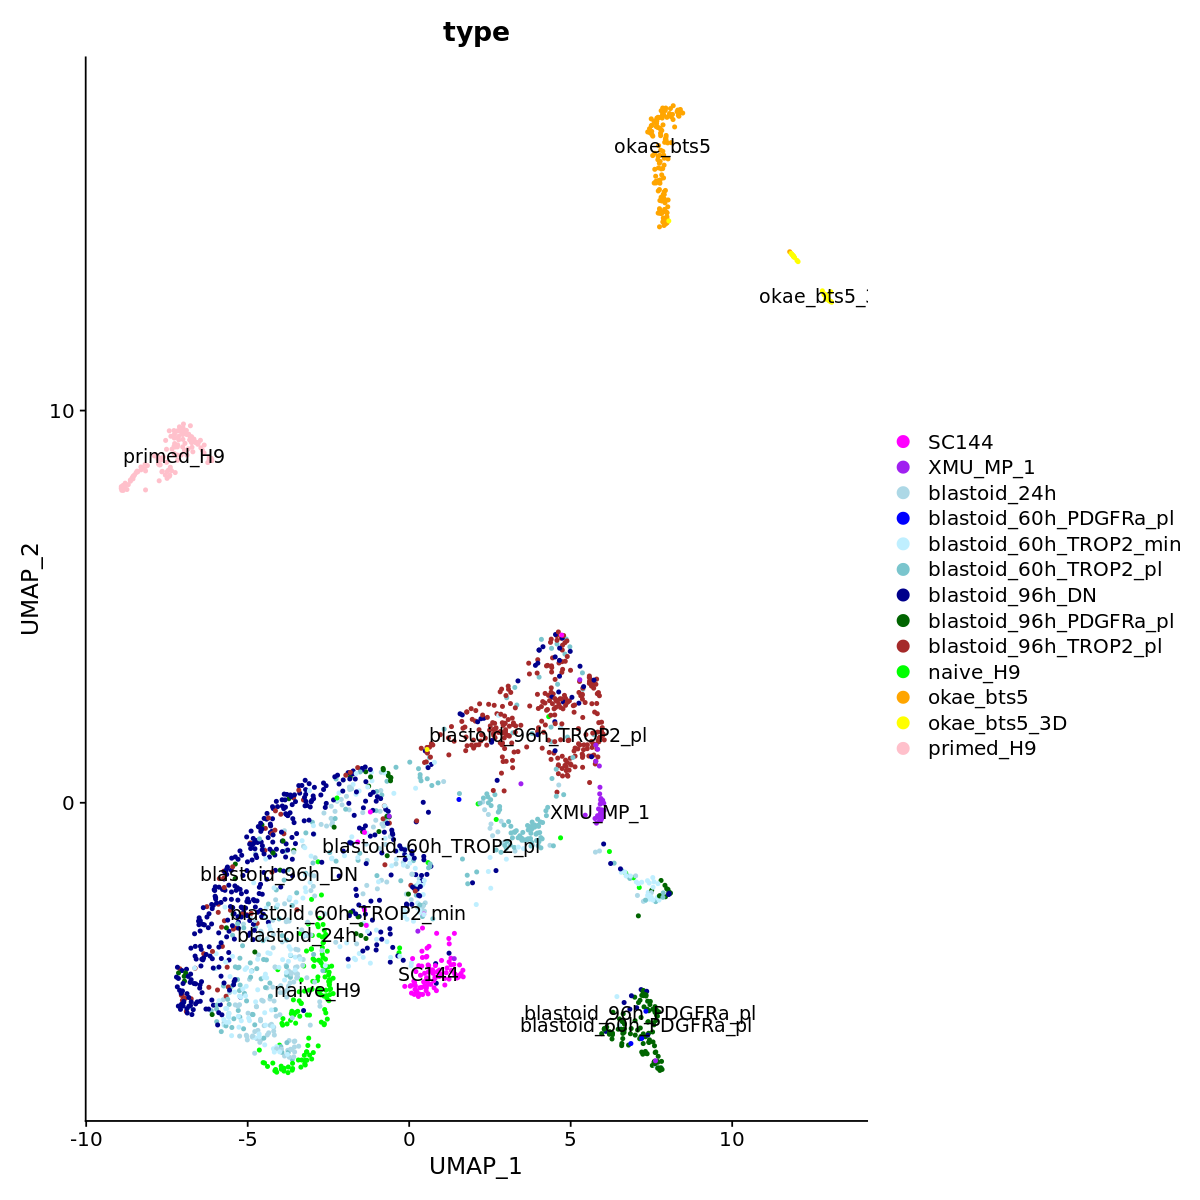

In [51]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(rivronSeurat, reduction = "umap", label = T)
DimPlot(rivronSeurat, reduction = "umap", group.by="type",
       cols=c("magenta", "purple", "light blue", "blue", "lightblue1", "cadetblue3", "dark blue", "dark green", "brown", "green", "orange", "yellow", "pink"), label=T)

In [117]:
rivronSeurat@meta.data$manualClusters <- NA
rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$seurat_clusters%in%c(0))] <- "epi"
rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$seurat_clusters%in%c(1))] <- "TE"
rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$seurat_clusters%in%c(2))] <- "naive"
rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$seurat_clusters%in%c(3))] <- "primed"
rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$seurat_clusters%in%c(4))] <- "PE"
rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$seurat_clusters%in%c(5))] <- "EXM"

In [118]:
levels(rivronSeurat@meta.data$manualClusters) <- c("naive", "primed", "epiblast", "primitive endoderm", "trophectoderm", "exta-embyronic mesoderm")

<h3> Figure S7A </h3>

In [154]:
pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/96hBlastoid.umap.pdf", width=4, height=4)
DimPlot(rivronSeurat, reduction = "umap", group.by="manualClusters", label=T, label.size = 3, pt.size = 0.5)+
theme(axis.line =element_blank(), axis.ticks = element_blank(), axis.text = element_blank(), legend.position = "none")+xlab("")+ylab("")+ggtitle("")
dev.off()

png 
  2

In [158]:
table(rivronSeurat@meta.data$type, rivronSeurat@meta.data$manualClusters)

                        
                         naive primed epiblast primitive endoderm trophectoderm exta-embyronic mesoderm
  blastoid_96h_DN            4      0      380                 10            40                       4
  blastoid_96h_PDGFRa_pl     1      0       37                 98             1                      11
  blastoid_96h_TROP2_pl      2      0       54                  0           278                       0
  naive_H9                 127      0        5                  0             4                       3
  primed_H9                  0    122        1                  0             0                       0

In [163]:
round(table(rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl"))])/
length(which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl")))*100, digits=0)


                  naive                  primed                epiblast      primitive endoderm           trophectoderm exta-embyronic mesoderm 
                      1                       0                      51                      12                      35                       2 

In [175]:
table(rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl"))])


 naive primed    epi     PE     TE    EXM 
     7      0    471    108    319     15 

In [164]:
data.frame(table(rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl"))])/
length(which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl")))*100)

Var1,Freq
<fct>,<dbl>
naive,0.7608696
primed,0.0000000
epiblast,51.1956522
primitive endoderm,11.7391304
trophectoderm,34.6739130
exta-embyronic mesoderm,1.6304348


In [170]:
levels(rivronSeurat@meta.data$manualClusters) <- c("naive", "primed", "epi", "PE", "TE", "EXM")

In [172]:
pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/96hBlastoid.distribution.pdf", width=4, height=4)
ggplot(data.frame(table(rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl"))])/
length(which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl")))*100), aes(x=Var1, y=Freq))+geom_bar(stat="identity")+theme_linedraw()+
xlab("cell type")+ylab("% of blastoid cells")+theme(text=element_text(size=9), panel.grid.minor = element_blank(), panel.grid.major.x = element_blank())
dev.off()

png 
  2

In [8]:
feats.core <- c("POU5F1","SOX2","NANOG")
feats.primed <- c("OTX2", "ZIC2", "CD24", "DUSP6", "TCF4")
feats.naive <- c("KLF17", "KLF4", "SUSD2", "DNMT3L", "DPPA5", "TFCP2L1")
feats.TE <- c("GATA2","GATA3","KRT7","KRT18","HAND1","NR2F2")
feats.EXMC <- c("LUM","NID2", "FOXF1", "VIM", "POSTN", "ANXA1",  "PITX1")
feats.PrE <- c("SOX17", "GATA4", "GATA6", "FOXA2", "PDGFRA")
feats.EVT <- c("HLA-G", "MMP2")
feats.STB <- c("CGA",  "SDC1")
feats.amnion<- c("WNT6", "GABRP", "ISL1", "HEY1", "CDH10", "CTSV", "TPM1")
feats.mesoderm <- c("MIXL1", "MESP1", "EPHA4", "ZIC3", "GSC", "TBXT", "CDX1", "CDX2", "CDX4", "EOMES")

In [9]:
combinedFeats <- list(core=feats.core, primed=feats.primed, naive=feats.naive, trophectoderm=feats.TE, EXMC=feats.EXMC, PE=feats.PrE, EVT=feats.EVT, STB=feats.STB, amnin=feats.amnion, mesoderm=feats.mesoderm)

In [103]:
rivronSeurat@meta.data$manualClusters <- factor(rivronSeurat@meta.data$manualClusters, levels=c("naive", "primed", "epi", "PE", "TE", "EXM"))

In [121]:
blastoidSeurat <- subset(rivronSeurat, subset = manualClusters%in%c("epi", "PE", "TE", "EXM"))

In [123]:
blastoidSeurat@meta.data$manualClusters <- as.character(blastoidSeurat@meta.data$manualClusters)
blastoidSeurat@meta.data$manualClusters <- factor(blastoidSeurat@meta.data$manualClusters, levels=c("epi","PE", "TE", "EXM"))

In [66]:
options(repr.plot.width=20, repr.plot.height=10)
DoHeatmap(blastoidSeurat, group.by="manualClusters",  angle=0,hjust=0.5, size=3,
          features=c(feats_epi.vincent,feats_PE.vincent,feats_TE.vincent, feats.EXM, feats.AM))+
geom_hline(yintercept = c(length(which(feats.AM%in%rownames(rivronSeurat)))+0.5,
                         length(which(feats.AM%in%rownames(rivronSeurat)))+length(which(feats.EXM%in%rownames(rivronSeurat)))+0.5,
                         length(which(feats.AM%in%rownames(rivronSeurat)))+length(which(feats.EXM%in%rownames(rivronSeurat)))+length(which(feats_TE.vincent%in%rownames(rivronSeurat)))+0.5,
                         length(which(feats.AM%in%rownames(rivronSeurat)))+length(which(feats.EXM%in%rownames(rivronSeurat)))+length(which(feats_PE.vincent%in%rownames(rivronSeurat)))+length(which(feats_TE.vincent%in%rownames(rivronSeurat)))+0.5),
          size=2, color="white")+scale_fill_viridis(option="D")+
      guides(color="none")+ylab("lineage markers")+
      theme(text=element_text(size=7, face="bold"), legend.position = "bottom")

ERROR: Error in is.data.frame(x): object 'blastoidSeurat' not found


In [35]:
pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/96hBlastoid.Heatmap.pdf", width=8.3, height=6.3)
DoHeatmap(blastoidSeurat, group.by="manualClusters",  angle=0,hjust=0.5, size=3,
          features=c(feats_epi.vincent,feats_PE.vincent,feats_TE.vincent, feats.EXM, feats.AM))+
geom_hline(yintercept = c(length(which(feats.AM%in%rownames(rivronSeurat)))+0.5,
                         length(which(feats.AM%in%rownames(rivronSeurat)))+length(which(feats.EXM%in%rownames(rivronSeurat)))+0.5,
                         length(which(feats.AM%in%rownames(rivronSeurat)))+length(which(feats.EXM%in%rownames(rivronSeurat)))+length(which(feats_TE.vincent%in%rownames(rivronSeurat)))+0.5,
                         length(which(feats.AM%in%rownames(rivronSeurat)))+length(which(feats.EXM%in%rownames(rivronSeurat)))+length(which(feats_PE.vincent%in%rownames(rivronSeurat)))+length(which(feats_TE.vincent%in%rownames(rivronSeurat)))+0.5),
          size=0.5, color="white")+scale_fill_viridis(option="D")+
      guides(color="none")+ylab("lineage markers")+
      theme(text=element_text(size=7, face="bold"), legend.position = "bottom")
    dev.off()

ERROR: Error in is.data.frame(x): object 'blastoidSeurat' not found


In [157]:
saveRDS(rivronSeurat, "/staging/leuven/stg_00041/Bradley/rivronData/rivron.seurat.rds")

In [3]:
rivronSeurat <- readRDS("/staging/leuven/stg_00041/Bradley/rivronData/rivron.seurat.rds")

In [176]:
Idents(rivronSeurat) <- rivronSeurat@meta.data$manualClusters

In [67]:
load("../inegrate.PRTwPasqueEXM.Robject")

In [68]:
rownames(rivronSeurat@meta.data)[1:5]
combinedCountsSeuratReintegrated@meta.data$cell[1:5]

rivronSeurat@meta.data$cell <- lapply(rownames(rivronSeurat@meta.data), gsub, pattern="-", replacement=".")


[1] "primed_H9-150182" "primed_H9-150183" "primed_H9-150185" "primed_H9-150187" "primed_H9-150188"

[1] "primed_H9.150182" "primed_H9.150183" "primed_H9.150185" "primed_H9.150187" "primed_H9.150188"

In [69]:
summary(rivronSeurat@meta.data$cell%in%combinedCountsSeuratReintegrated@meta.data$cell)

   Mode   FALSE    TRUE 
logical     915    1174 

In [90]:
rivronSeurat@meta.data$manualCluster <- "not96h"

for(i in 1:nrow(rivronSeurat@meta.data)){
    if(rivronSeurat@meta.data$cell[i]%in%combinedCountsSeuratReintegrated@meta.data$cell){
   rivronSeurat@meta.data$manualCluster[i] <- combinedCountsSeuratReintegrated@meta.data$finalLabels[which(
       combinedCountsSeuratReintegrated@meta.data$cell==rivronSeurat@meta.data$cell[i])]
        }
}

In [99]:
table(rivronSeurat$manualCluster,rivronSeurat$seurat_clusters)

                        
                           0   1   2   3   4   5   6   7
  blastoid EXM             0   2   0   0   0   0   0  16
  blastoid PE              0   0   0   1   0   0 107   0
  blastoid TE              0 322   0   0   0   0   0   1
  blastoid epiblast      202   3 196  67   0   0   1   0
  blastoid_96h_DN          4   0   0   0   0   0   0   0
  blastoid_96h_PDGFRa_pl   1   0   0   0   0   0   0   0
  blastoid_96h_TROP2_pl    1   0   1   0   0   0   0   0
  naive_H9               117   1   8   1   0   0   0   0
  not96h                 265 179 148 133 149   0   7  34
  primed_H9                0   0   0   0   0 122   0   0

In [112]:
round(table(rivronSeurat$type,rivronSeurat$seurat_clusters)/as.numeric(table(rivronSeurat$type))*100)

                        
                          0  1  2  3  4  5  6  7
  SC144                   0  1  2 97  0  0  0  0
  XMU_MP_1                0 89  0  9  0  0  3  0
  blastoid_24h           59  8 29  2  0  0  0  2
  blastoid_60h_PDGFRa_pl  0 25  0  0  0  0 75  0
  blastoid_60h_TROP2_min 42  6 24 16  0  0  1 12
  blastoid_60h_TROP2_pl  30 47 15  3  0  0  0  4
  blastoid_96h_DN        38 10 37 12  0  0  2  1
  blastoid_96h_PDGFRa_pl  6  1 12  7  0  0 66  7
  blastoid_96h_TROP2_pl  10 83  6  1  0  0  0  0
  naive_H9               84  4  8  2  0  0  0  1
  okae_bts5               0  1  0  0 99  0  0  0
  okae_bts5_3D            0 32  0  0 68  0  0  0
  primed_H9               0  0  1  0  0 99  0  0

In [259]:
table(rivronSeurat$type,rivronSeurat$seurat_clusters)

                        
                           0   1   2   3   4   5   6   7
  naive_H9               117   6  11   3   0   0   0   2
  primed_H9                0   0   1   0   0 122   0   0
  SC144                    0   1   2  90   0   0   0   0
  XMU_MP_1                 0  31   0   3   0   0   1   0
  blastoid_24h           118  17  58   3   0   0   0   4
  blastoid_60h_PDGFRa_pl   0   1   0   0   0   0   3   0
  blastoid_60h_TROP2_min  79  11  46  30   0   0   2  22
  blastoid_60h_TROP2_pl   68 106  34   7   0   0   1   8
  blastoid_96h_DN        165  43 164  52   0   0  10   4
  blastoid_96h_PDGFRa_pl   9   1  18  11   0   0  98  11
  blastoid_96h_TROP2_pl   34 278  19   3   0   0   0   0
  okae_bts5                0   1   0   0 126   0   0   0
  okae_bts5_3D             0  11   0   0  23   0   0   0

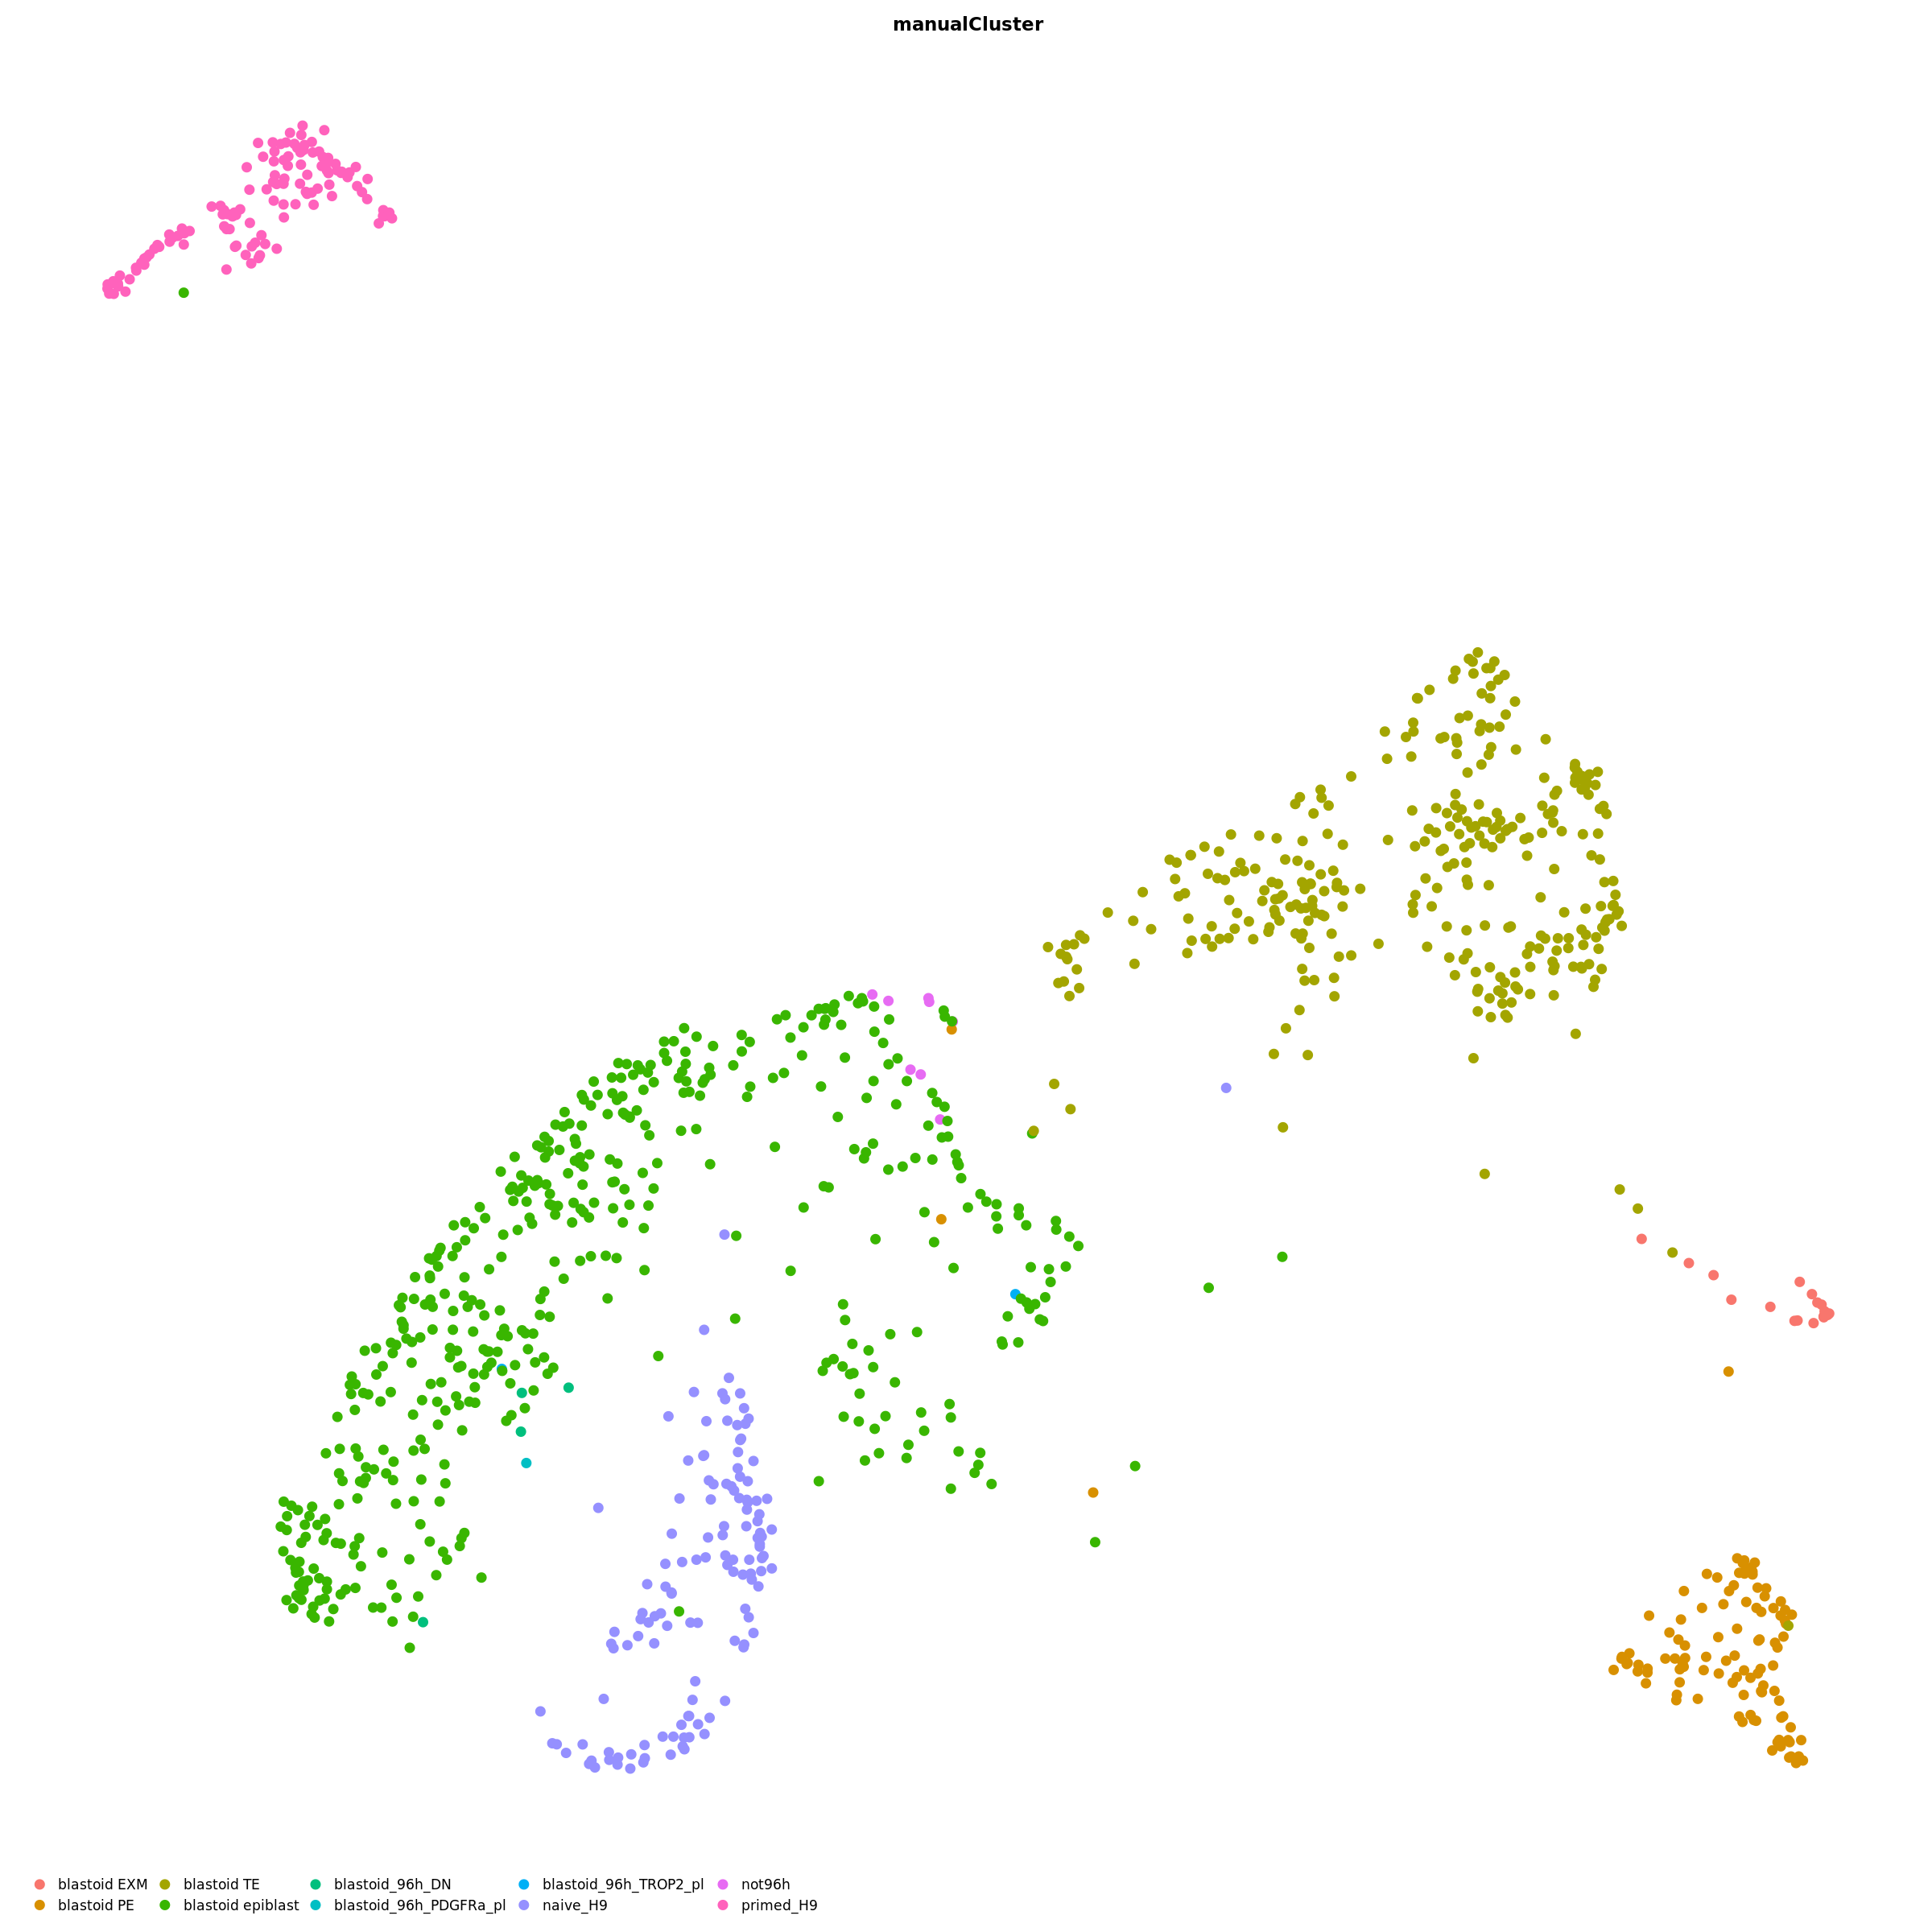

In [ ]:
#pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/rivronColoredByEXMpaperBlastoidClusters.only96hBlastoids.pdf", width=4.25, height=4)
DimPlot( rivronSeurat, reduction = "umap", group.by="manualCluster", 
        cells = which(rivronSeurat$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl", "naive_H9", "primed_H9")),
        pt.size=3)+
#scale_color_manual(values=c("red", "orange", "blue", "green", "purple", "yellow"), na.translate=F)+
theme(text=element_text(size=12), legend.position = "bottom", axis.ticks = element_blank(), axis.line = element_blank(), axis.text=element_blank())+xlab(NULL)+ylab(NULL)
#dev.off()

In [123]:
rivronSeurat@meta.data$manualClusters[which(rivronSeurat@meta.data$type=="naive_H9")] <- "naive"

In [159]:
options(repr.plot.width=10, repr.plot.height=10)
pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/rivronColoredByEXMpaperBlastoidClusters.only96hBlastoids.pdf", width=4.25, height=4)
DimPlot( rivronSeurat, reduction = "umap", group.by="manualCluster", 
        cells = which(rivronSeurat$type%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl", "naive_H9", "primed_H9")&
                     !is.na(rivronSeurat@meta.data$manualCluster)),
        pt.size=0.5)+ggtitle("")+
#scale_color_manual(values=c("red", "orange", "blue", "green", "purple", "yellow"), na.translate=F)+
theme(text=element_text(size=12), legend.position = "bottom", axis.ticks = element_blank(), axis.line = element_blank(), axis.text=element_blank())+xlab(NULL)+ylab(NULL)
dev.off()

png 
  2

In [150]:
rivronSeurat@meta.data[which(is.na(rivronSeurat@meta.data$manualCluster)),]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters,type,cell,manualCluster,RNA_snn_res.0.3,RNA_snn_res.0.2
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<chr>,<list>,<chr>,<fct>,<fct>
blastoid_96h_PDGFRa_pl-154503,blastoid,150176,3251,0.1032122,8,0,blastoid_96h_PDGFRa_pl,blastoid_96h_PDGFRa_pl.154503,NA,0,0
blastoid_96h_PDGFRa_pl-156045,blastoid,173308,2811,1.6987098,8,0,blastoid_96h_PDGFRa_pl,blastoid_96h_PDGFRa_pl.156045,NA,0,0
blastoid_96h_PDGFRa_pl-156084,blastoid,121021,3205,0.3842308,8,0,blastoid_96h_PDGFRa_pl,blastoid_96h_PDGFRa_pl.156084,NA,0,0
blastoid_96h_DN-156091,blastoid,151824,3694,4.8193961,8,0,blastoid_96h_DN,blastoid_96h_DN.156091,NA,0,0
blastoid_96h_DN-156139,blastoid,161465,2735,7.9992568,8,0,blastoid_96h_DN,blastoid_96h_DN.156139,NA,0,0
blastoid_96h_DN-157616,blastoid,172898,2549,0.7756018,8,0,blastoid_96h_DN,blastoid_96h_DN.157616,NA,0,0
blastoid_96h_DN-159651,blastoid,134170,3476,2.6041589,8,0,blastoid_96h_DN,blastoid_96h_DN.159651,NA,0,0
blastoid_96h_PDGFRa_pl-159769,blastoid,155594,2747,0.0000000,8,0,blastoid_96h_PDGFRa_pl,blastoid_96h_PDGFRa_pl.159769,NA,0,0


In [153]:
table(rivronSeurat@meta.data$manualCluster, rivronSeurat@meta.data$seurat_clusters, useNA="always")

           
              0   1   2   3   4   5 <NA>
  EXM         0   3   0   0   1  15    0
  Epi       451   0   7   0   1   0    0
  PE          7   0   0   0 106   0    0
  TE          5 316   0   0   0   0    0
  naive_H9    5   4 127   0   0   3    0
  primed_H9   1   0   0 122   0   0    0
  <NA>        8   0   0   0   0   0    0

In [140]:
#96h only, which naive cluster with EXMC
#rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data$seurat_clusters==5 & rivronSeurat@meta.data$type=="naive_H9")]

[[1]]
[1] "naive_H9.150444"

[[2]]
[1] "naive_H9.150515"

[[3]]
[1] "naive_H9.150537"

In [142]:
#all blastoids, which naive cluster with EXMC
rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data$seurat_clusters==7 & rivronSeurat@meta.data$type=="naive_H9")]

[[1]]
[1] "naive_H9.150444"

[[2]]
[1] "naive_H9.150515"

In [139]:
table(rivronSeurat@meta.data$seurat_clusters, rivronSeurat@meta.data$manualClusters)

   
    EXM  PE  TE epi naive primed
  0   0   0   0 472     5      0
  1   0   0 319   0     4      0
  2   0   0   0   0   134      0
  3   0   0   0   0     0    122
  4   0 108   0   0     0      0
  5  15   0   0   0     3      0

In [92]:
rivronSeurat@meta.data$manualCluster[which(
    !rivronSeurat@meta.data$manualCluster%in%c("blastoid EXM", "blastoid PE", "blastoid TE", "blastoid epiblast", "naive_H9", "primed_H9"))] <-
rivronSeurat@meta.data$seurat_clusters[which(
    !rivronSeurat@meta.data$manualCluster%in%c("blastoid EXM", "blastoid PE", "blastoid TE", "blastoid epiblast", "naive_H9", "primed_H9"))]

In [96]:
#coloring based on lineage. 
#cluster lineage: 8 is EXMC, 7 is PE, 1 is naive, 6 is primed, 5 is okae TS, 2 blastoid TE, 3,4 are epiblast?

pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/rivronColoredByEXMpaperBlastoidClusters.allBlastoids.pdf", width=8.5, height=8.5)
options(repr.plot.width=20, repr.plot.height=10)
DimPlot(rivronSeurat, reduction = "umap", group.by="manualCluster", pt.size = 1.5)+
scale_color_manual(values=c("1"="dark red", "2"="dark blue", "3"="darkseagreen2", "4"="darkkhaki", "5"="cadet blue4", "7"="dark green", "8"="purple", "blastoid EXM"="magenta", "blastoid PE"="orange", "blastoid TE"="light blue", "blastoid epiblast"="red", "naive_H9"="pink","primed_H9"="green"))+
ggtitle("blastoid umap, all rivron cells")+theme(text=element_text(size=12))
dev.off()



png 
  2

Getting coordinates for horizontal white lines to divide gene types

In [40]:
divLines <- c()
count=0
for(i in 1:length(combinedFeats)){
        divLines <- c(divLines, count+length(which(combinedFeats[[i]]%in%rownames(rivronSeurat@assays$RNA)))+0.5)
        count=count+length(which(combinedFeats[[i]]%in%rownames(rivronSeurat@assays$RNA)))
    
}


In [41]:
divLines

[1]  3.5  8.5 14.5 20.5 28.5 33.5 35.5 37.5 44.5 53.5

In [80]:
rivronSeurat@meta.data$type <- factor(rivronSeurat@meta.data$type, levels= levels(as.factor(rivronSeurat@meta.data$type))[c(10,13, 1:9,11,12)])


save and load completed seurats. with only 96h and with all blastoid cells

In [27]:
#save(rivronSeurat, file="rivron.allBlastoids.seurat.Robject")

In [52]:
#save(rivronSeurat, file="rivron.96hBlastoid.seurat.Robject")

In [12]:
load("rivron.allBlastoids.seurat.Robject")

In [17]:
load("rivron.96hBlastoid.seurat.Robject")

graphing expression umapsFeaturePlot(rivronSeurat, features = feat, reduction="umap", pt.size=1, ncol=2)

In [117]:
table(rivronSeurat@meta.data$type)


       blastoid_96h_DN blastoid_96h_PDGFRa_pl  blastoid_96h_TROP2_pl               naive_H9              primed_H9 
                   438                    148                    334                    139                    123 

In [6]:
rivronSeurat <- ScaleData(rivronSeurat , verbose=F, features = rownames(rivronSeurat@assays$RNA))

<h3>publication graphs of blastoid time points and EXMC (Figure S7E) </h3>

In [13]:
rivronSeurat@meta.data$time <- NA

rivronSeurat@meta.data$time[which(rivronSeurat@meta.data$type%in%c("naive_H9"))] <- 0
rivronSeurat@meta.data$time[which(rivronSeurat@meta.data$type%in%c("blastoid_24h"))] <- 24
rivronSeurat@meta.data$time[which(rivronSeurat@meta.data$type%in%c("blastoid_60h_PDGFRa_pl", "blastoid_60h_TROP2_min", "blastoid_60h_TROP2_pl"))] <- 60
rivronSeurat@meta.data$time[which(rivronSeurat@meta.data$type%in%c("blastoid_96h_DN","blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl"))] <- 96

In [14]:
table(rivronSeurat@meta.data$type, rivronSeurat@meta.data$time)

                        
                           0  24  60  96
  blastoid_24h             0 200   0   0
  blastoid_60h_PDGFRa_pl   0   0   4   0
  blastoid_60h_TROP2_min   0   0 190   0
  blastoid_60h_TROP2_pl    0   0 224   0
  blastoid_96h_DN          0   0   0 438
  blastoid_96h_PDGFRa_pl   0   0   0 148
  blastoid_96h_TROP2_pl    0   0   0 334
  naive_H9               139   0   0   0
  okae_bts5                0   0   0   0
  okae_bts5_3D             0   0   0   0
  primed_H9                0   0   0   0
  SC144                    0   0   0   0
  XMU_MP_1                 0   0   0   0

In [19]:
feats.core <- c("POU5F1", "SOX2","NANOG")
feats.primed <- c("OTX2", "ZIC2", "CD24", "DUSP6", "TCF4")
feats.naive <- c("KLF17", "KLF4", "SUSD2", "DNMT3L", "DPPA5", "TFCP2L1")
feats.TE <- c("GATA2","GATA3","ITGA6","TP63","KRT7","KRT18","HAND1","NR2F2")
feats.EXMC <- c("LUM","NID2", "FOXF1", "VIM", "POSTN", "ANXA1")#,  "PITX1")#, "BST2", "DCN")
feats.PrE <- c("SOX17", "GATA4", "GATA6", "FOXA2", "PDGFRA","CDH2")
feats.EVT <- c("HLA-G", "MMP2", "ITGA5")
feats.STB <- c("CGA", "CGB3", "SDC1")
feats.amnion<- c("WNT6", "GABRP", "ISL1", "HEY1", "CDH10", "CTSV", "TPM1")
feats.mesoderm <- c("MIXL1", "MESP1", "ZIC3",  "TBXT", "CDX1", "CDX2", "CDX4", "EOMES")

In [20]:
combinedFeats <- list(core=feats.core, primed=feats.primed, naive=feats.naive, trophectoderm=feats.TE, EXMC=feats.EXMC, PE=feats.PrE, EVT=feats.EVT, STB=feats.STB, amnin=feats.amnion, mesoderm=feats.mesoderm)

In [21]:
pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/rivron.blastoidTime.EXMCcluster.pdf", width=6, height=4)
DoHeatmap(rivronSeurat, group.by="time",cells=which(rivronSeurat@meta.data$seurat_clusters==7 & rivronSeurat@meta.data$time%in%c(0, 24,60,96)), 
          features=unlist(combinedFeats), angle=0, hjust=0.5, size = 2.5)+scale_fill_viridis(option="A")#+theme(legend.position="none")
dev.off()

Warning message in DoHeatmap(rivronSeurat, group.by = "time", cells = which(rivronSeurat@meta.data$seurat_clusters == :
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: CGB3”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



png 
  2

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



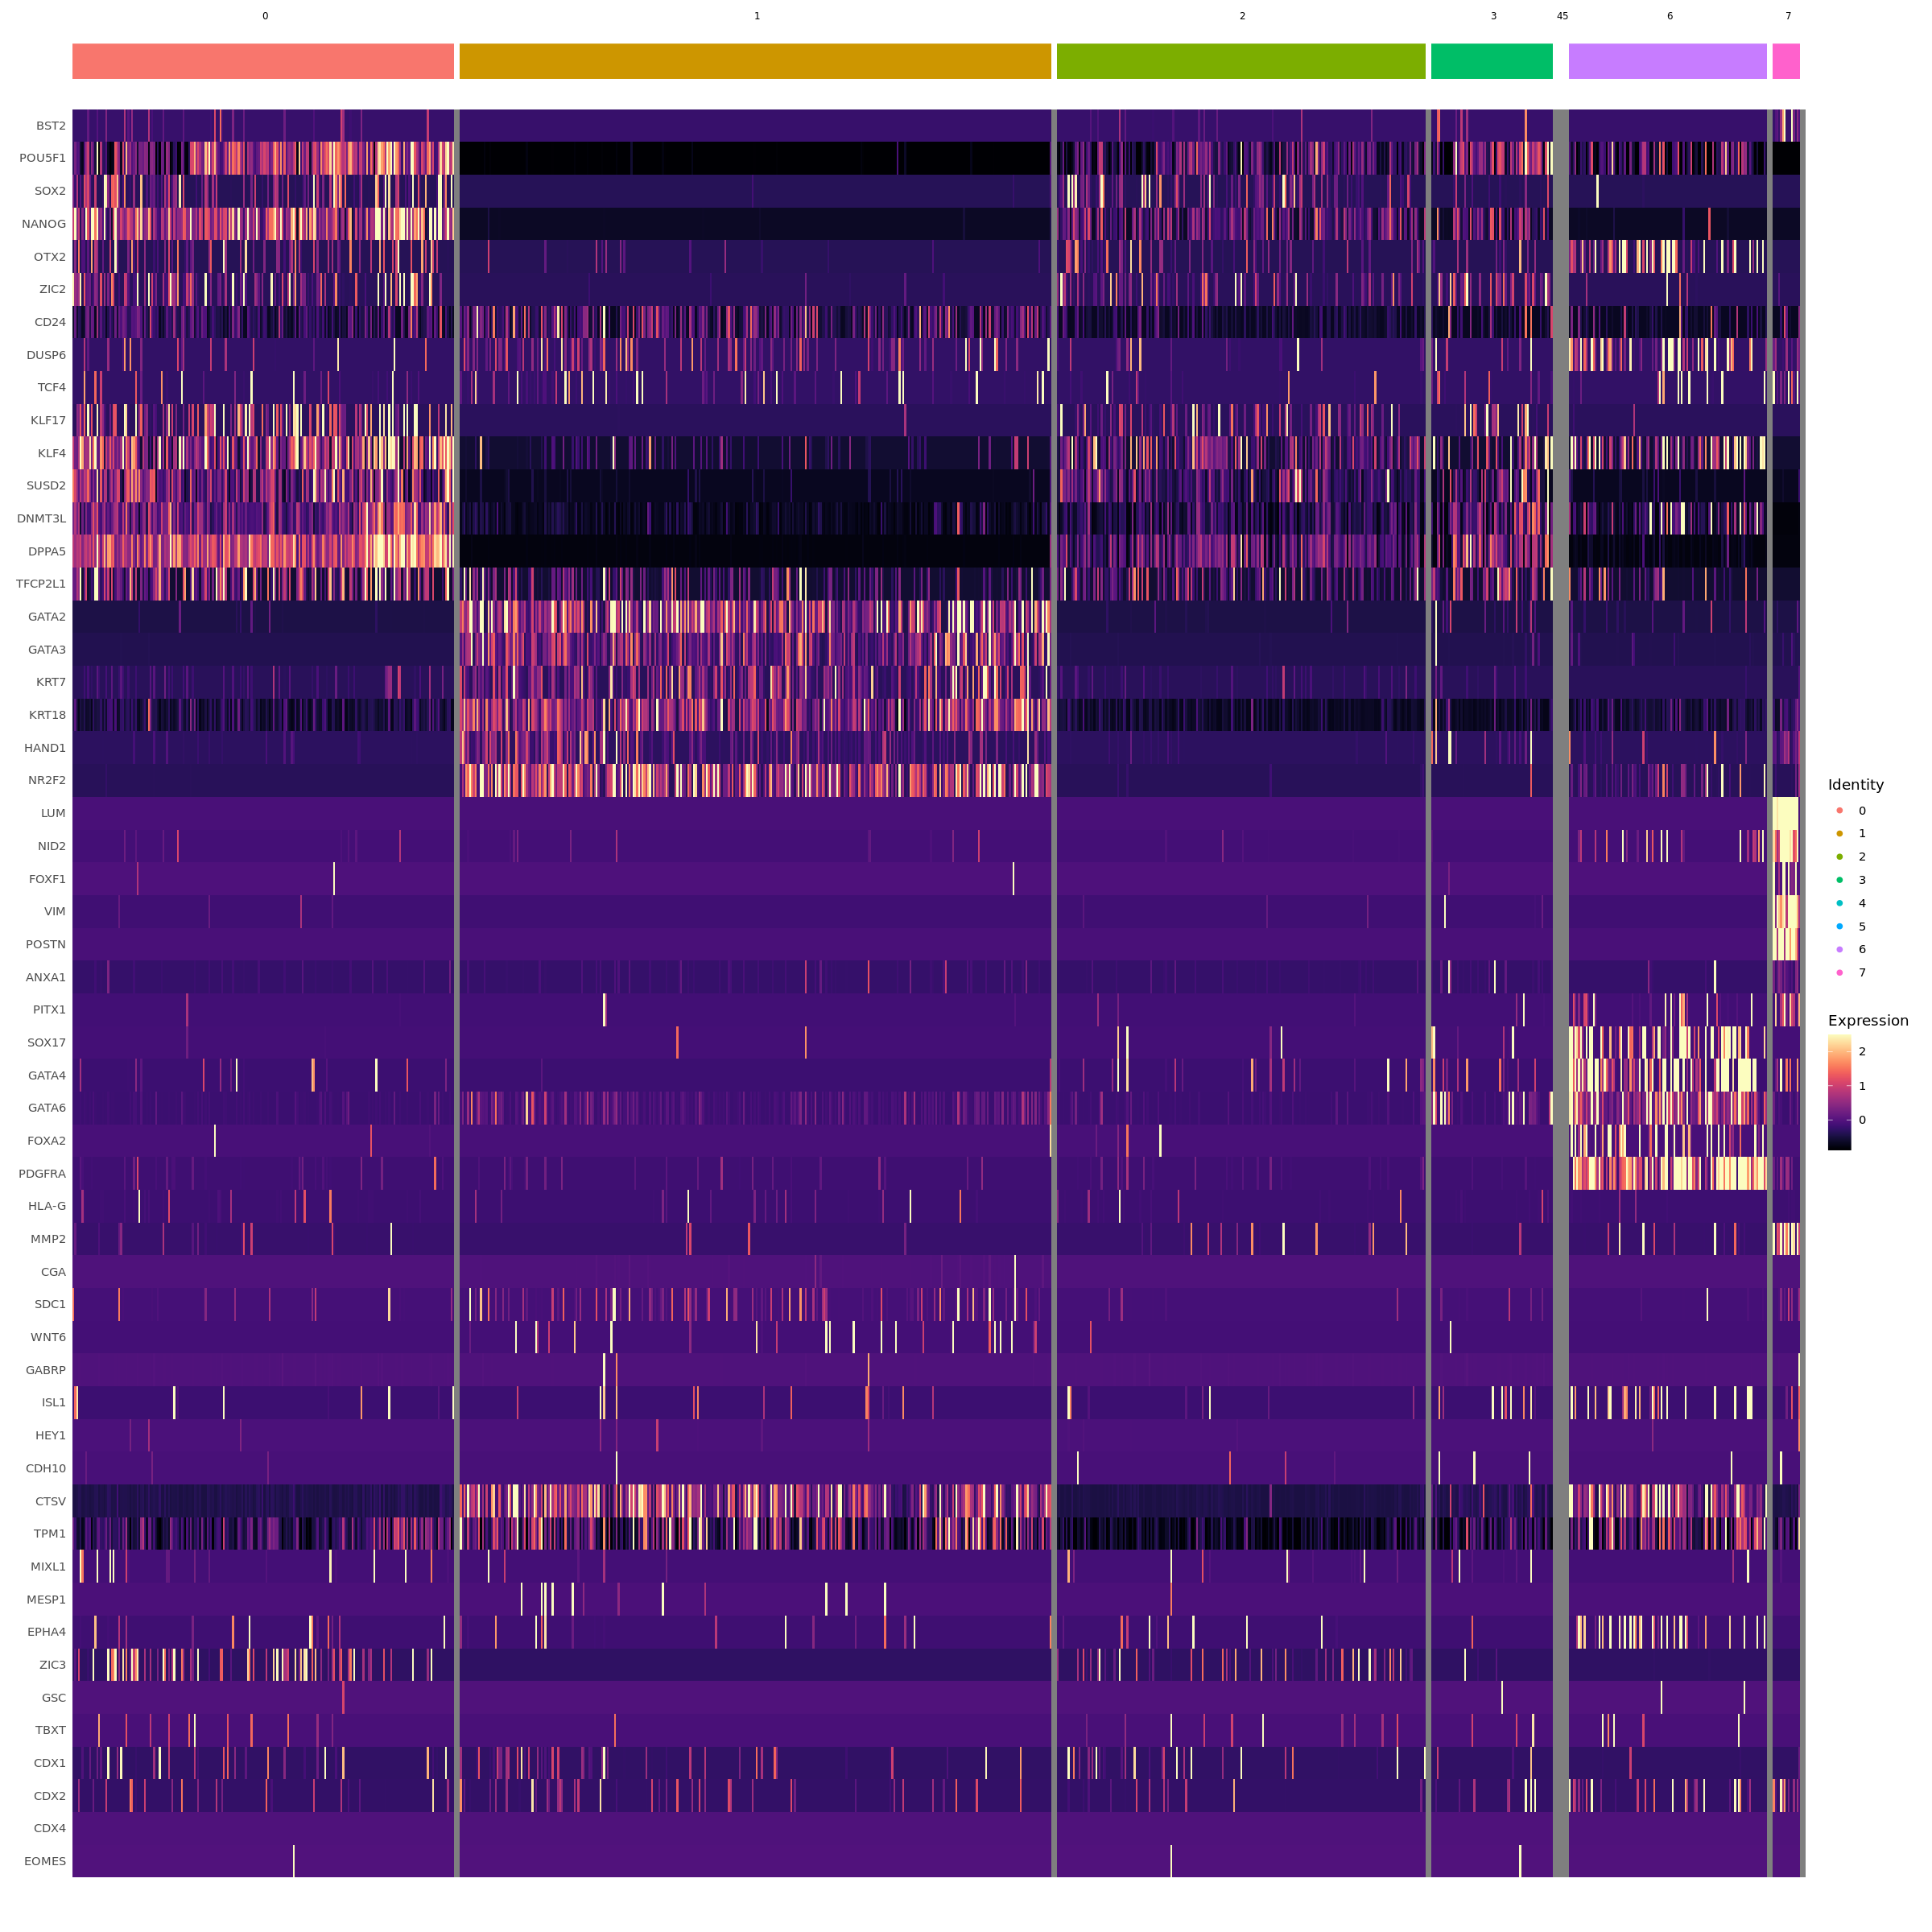

In [84]:
#pdf("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/rivron.blastoidTime.EXMCcluster.pdf", width=6, height=4)
DoHeatmap(rivronSeurat, group.by="seurat_clusters",cells=which(rivronSeurat@meta.data$time%in%c(96)),# & rivronSeurat@meta.data$seurat_clusters==7), 
          features=c("BST2",unlist(combinedFeats))
          , angle=0, hjust=0.5, size = 2.5)+scale_fill_viridis(option="A")#+theme(legend.position="none")
#dev.off()

In [22]:
jpeg("/data/leuven/343/vsc34313/jupyter_notebooks/rivron/rivron.blastoidTime.notEXMCcluster.jpeg", width=1920, height=1080)
DoHeatmap(rivronSeurat, group.by="time",cells=which(rivronSeurat@meta.data$seurat_clusters!=7 & !is.na(rivronSeurat$time)), features=unlist(combinedFeats), angle=0, hjust=0.5, size = 2.5)+scale_fill_viridis(option="A")#+theme(legend.position="none")
dev.off()

Warning message in DoHeatmap(rivronSeurat, group.by = "time", cells = which(rivronSeurat@meta.data$seurat_clusters != :
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: CGB3”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



png 
  2

In [ ]:
DoHeatmap(rivronSeurat, group.by="time",cells=which(rivronSeurat@meta.data$seurat_clusters!=7 & !is.na(rivronSeurat$time)), features=unlist(combinedFeats), angle=0, hjust=0.5, size = 2.5)+scale_fill_viridis(option="A")#+theme(legend.position="none")


In [18]:
head(rivronSeurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters,type,RNA_snn_res.0.2,cell,manualCluster,time
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<chr>,<fct>,<list>,<chr>,<dbl>
primed_H9-150182,rivronData,1508453,7849,6.808896,6,5,primed_H9,5,primed_H9.150182,primed_H9,NA
primed_H9-150183,rivronData,921808,7602,6.181548,6,5,primed_H9,5,primed_H9.150183,primed_H9,NA
primed_H9-150185,rivronData,871460,6154,7.012026,6,5,primed_H9,5,primed_H9.150185,primed_H9,NA
primed_H9-150187,rivronData,1508596,7564,7.557689,6,5,primed_H9,5,primed_H9.150187,primed_H9,NA
primed_H9-150188,rivronData,1391567,5377,4.021797,6,5,primed_H9,5,primed_H9.150188,primed_H9,NA
primed_H9-150189,rivronData,1340044,6258,3.559958,6,5,primed_H9,5,primed_H9.150189,primed_H9,NA


In [20]:
load("../inegrate.PRTwPasqueEXM.Robject")

In [24]:
unique(combinedCountsSeuratReintegrated@meta.data$finalLabels)

[1] "primed_H9"                         "blastoid epiblast"                
 [3] "naive_H9"                          "blastoid EXM"                     
 [5] "blastoid TE"                       "blastoid_96h_TROP2_pl"            
 [7] "blastoid_96h_DN"                   "blastoid PE"                      
 [9] "blastoid_96h_PDGFRa_pl"            "EightCells"                       
[11] "Morula"                            "B1_B2"                            
[13] NA                                  "early_TE"                         
[15] "EPI"                               "medium_TE"                        
[17] "PrE"                               "late_TE"                          
[19] "TB.medium1"                        "TB.early"                         
[21] "TB.medium3"                        "Hemogenic Endothelial Progenitors"
[23] "Endoderm"                          "Advanced Mesoderm"                
[25] "Primitive Streak"                  "YS Mesoderm"                      
[27] "Axial Mesoderm"                    "Erythrocytes"                     
[29] "Emergent Mesoderm"                 "Epiblast"                         
[31] "Nascent Mesoderm"                  "Ectoderm"                         
[33] "primed_VP"                         "trophoblast_VP"                   
[35] "EXM_VP"                            "naive_VP"

In [25]:
rivronSeurat@meta.data$integrationLabels <- NA

rivronSeurat@meta.data$integrationLabels[which(
    rivronSeurat@meta.data$cell%in%combinedCountsSeuratReintegrated$cell[which(
        combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid EXM")])] <- "EXMC"
rivronSeurat@meta.data$integrationLabels[which(
    rivronSeurat@meta.data$cell%in%combinedCountsSeuratReintegrated$cell[which(
        combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid epiblast")])] <- "Epiblast"
rivronSeurat@meta.data$integrationLabels[which(
    rivronSeurat@meta.data$cell%in%combinedCountsSeuratReintegrated$cell[which(
        combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid PE")])] <- "PrE"
rivronSeurat@meta.data$integrationLabels[which(
    rivronSeurat@meta.data$cell%in%combinedCountsSeuratReintegrated$cell[which(
        combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid TE")])] <- "Trophoblast"

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



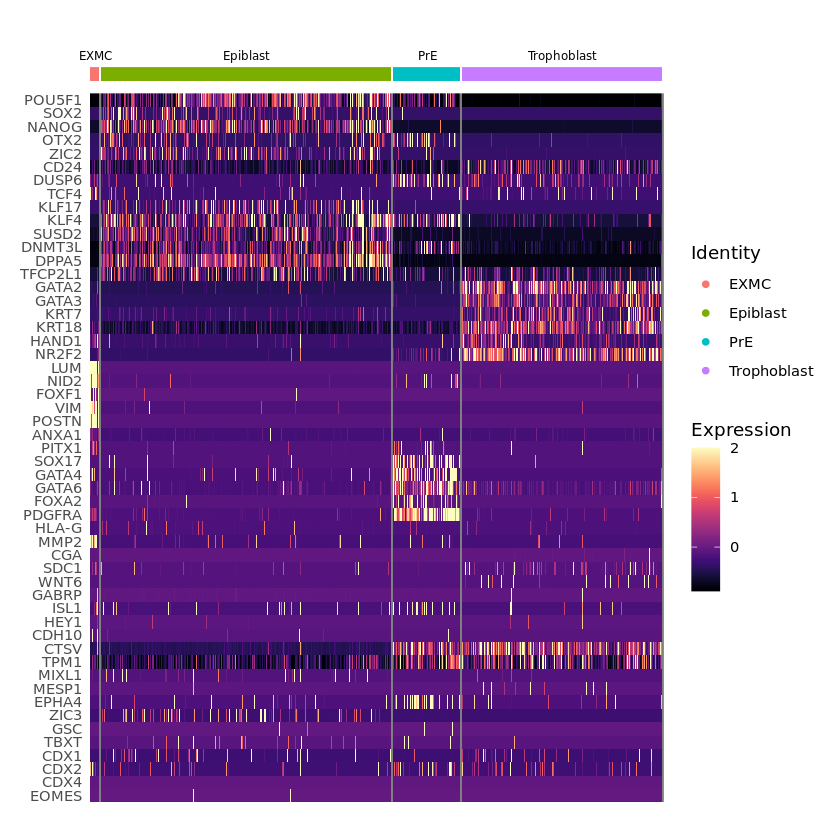

In [32]:
DoHeatmap(rivronSeurat, group.by="integrationLabels",cells=which(rivronSeurat@meta.data$time==96 & !is.na(rivronSeurat$integrationLabels)), features=unlist(combinedFeats), angle=0, hjust=0.5, size = 2.5, disp.min = -2, disp.max=2)+scale_fill_viridis(option="A")#+theme(legend.position="none")
# the problem with the color scale is that this scale doesnt go down to -2, there must not be anything in this dataset which goes that low... it makes everything else look lower than it should

In [33]:
clusterPerCellType <- function(cellType, addClust=0, columnName="integrationLabels"){
    temp <-rivronSeurat@assays$RNA@scale.data[, which(colnames(rivronSeurat@assays$RNA@scale.data)%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data[,columnName] %in%cellType)])]

    
    clust =hclust(d=dist(x =t(temp), method="euclidean"))
    
    customHeatmapData <- data.frame(order=1:length(clust$order), type=rivronSeurat@meta.data[which(colnames(rivronSeurat@assays$RNA@scale.data)%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data[,columnName]%in%cellType)]), columnName][clust$order], 
                                data=stack(as.data.frame(t(rivronSeurat@assays$RNA@scale.data[, which(colnames(rivronSeurat@assays$RNA@scale.data)%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data[,columnName]%in%cellType)])][,clust$order]))),
                               cell=rivronSeurat@meta.data$cell[which(colnames(rivronSeurat@assays$RNA@scale.data)%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data[,columnName]%in%cellType)])][clust$order])
    
    customHeatmapData$data.ind <- factor(customHeatmapData$data.ind, levels=unlist(combinedFeats)[which(unlist(combinedFeats)%in%unique(customHeatmapData$data.ind))])
    
    customHeatmapData$scaled.data <- customHeatmapData$data.values
    customHeatmapData$scaled.data[which(customHeatmapData$data.values>2)] <- 2
    customHeatmapData$scaled.data[which(customHeatmapData$data.values < -2)] <- -2
    
    #adding the length of previous clusters to order so that it will be able to be combined
    customHeatmapData$order <- customHeatmapData$order+addClust
    
    return(customHeatmapData)
}